## Data Formats 

The main difference between the handling of image classification datasets is the way labels are stored. This notebook includes all the ways of getting image data into a ImageDataBunch object. 

Note: In fastai we use an object called ImageDataBunch. An ImageDataBunch represents all of the data you need to build a model and there's some factory method which try to make it really easy for you to create that data bunch - a training set, a validation set with images and labels.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In this case, url is a string, fname is either path or a string and defaults to nothing (Union means "either"). dest is either a string or a path and defaults to nothing.

In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

[PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_img = path/'images'

In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [7]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c:Union[pathlib.Path, str], check_ext:bool=True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/keeshond_166.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Ragdoll_121.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/beagle_89.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/american_bulldog_171.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/pug_161.jpg')]

This is a pretty common way for computer vision datasets to get passed around - just one folder with a whole bunch of files in it. So the interesting bit then is how do we get the labels. If we just eyeball this, we could immediately see that the labels are actually part of the file names. It's kind of like path/label_number.extension. We need to somehow get a list of label bits of each file name, and that will give us our labels.

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

**Transforms** - We should check and transform the images to same size. So basically what it'll do is something called by default center cropping which means it'll grab the middle bit and it'll also resize it. We'll talk more about the detail of this because it turns out to actually be quite important, but basically it uses a combination of resizing, zooming and cropping. 

**Image size** - Models are designed so that the final layer is of size 7 by 7, so we actually want something where if you go 7 times 2 a bunch of times (224 = 7*2^5), then you end up with something that's a good size.. 224 by 224, for reasons we'll learn about, is an extremely common size that most models tend to use so if you just use size=224, you're probably going to get pretty good results most of the time. 

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64)


`ImageDataBunch.from_name_re` is going to return a `DataBunch` object. In fastai, everything you model with is going to be a DataBunch object. Basically DataBunch object contains 2 or 3 datasets - it contains your training data, validation data, and optionally test data. For each of those, it contains your images and your labels, your texts and your labels, or your tabular data and your labels, or so forth. And that all sits there in this one place(i.e. data).

## Other data formats

In [11]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ec2-user/.fastai/data/mnist_sample')

In [12]:
path.ls()

[PosixPath('/home/ec2-user/.fastai/data/mnist_sample/train'),
 PosixPath('/home/ec2-user/.fastai/data/mnist_sample/models'),
 PosixPath('/home/ec2-user/.fastai/data/mnist_sample/valid'),
 PosixPath('/home/ec2-user/.fastai/data/mnist_sample/labels.csv')]

### Scenario 1: Labels are folder names

In [13]:
(path/'train').ls()

[PosixPath('/home/ec2-user/.fastai/data/mnist_sample/train/7'),
 PosixPath('/home/ec2-user/.fastai/data/mnist_sample/train/3')]

There is a folder called 3 and a folder called 7. Now this is a really common way to give people labels. Basically it says everything that's a three, I put in a folder called three. Everything that's a seven, I'll put in a folder called seven. This is often called an "ImageNet style dataset" because this is how ImageNet is distributed. So if you have something in this format where the labels are just whatever the folders are called, you can say `from_folder`

In [14]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

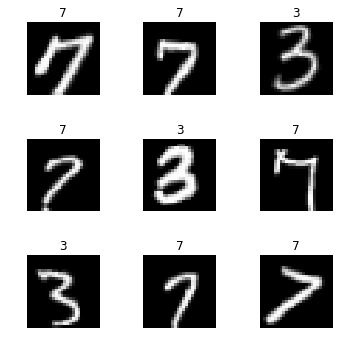

In [15]:
data.show_batch(rows=3, figsize=(5,5))

In [16]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.178977,0.090759,0.970559,00:23
1,0.109648,0.042154,0.987242,00:21


### Scenario 2: CSV file

Another possibility, and for this MNIST sample, I've got both, it might come with a CSV file that would look something like this. For each file name, what's its label. In this case, labels are not three or seven, they are 0 or 1 which basically is it a 7 or not. So that's another possibility. If this is how your labels are, you can use `from_csv`

And if it is called labels.csv, you don't even have to pass in a file name. If it's called something else, then you can pass in the csv_labels

In [17]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [18]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

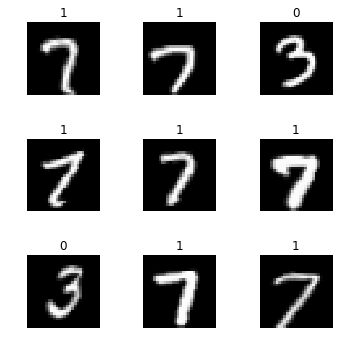

In [19]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

### Scenario 3: Using Dataframe

In [20]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

### Scenario 4: Using regex

In [21]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ec2-user/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ec2-user/.fastai/data/mnist_sample/train/3/21102.png')]

This is the same thing, these are the folders. But I could actually grab the label by using a regular expression. We've already seen this approach:

In [22]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

### Scenario 5: Something more complex

You can create an arbitrary function that extracts a label from the file name or path. In that case, you would say `from_name_func`:

In [23]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

### Scenario 6: You need something even more flexible

If you need something even more flexible than that, you're going to write some code to create an array of labels. So in that case, you can just use `from_lists` and pass in the array.

In [24]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [25]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']